# Single Subject Segmentation Q1K

In [1]:
# import packages
#import q1k_sync_tools as qst
import mne
import mne_bids
#mne.viz.set_browser_backend('qt')
#%matplotlib qt
import pandas as pd
pd.options.mode.chained_assignment = None
import pylossless as ll
import numpy as np
import glob

import matplotlib.pyplot as plt

from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_test
from mne.datasets import sample

<frozen importlib._bootstrap>:241: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_path = "/home/james/q1k/pilot/q1k-external-pilot/"
pylossless_path = "derivatives/pylossless/"
postproc_path = "derivatives/q1k_postproc/"
task_id_in = "ap"
task_id_out = "ap"
subject_id = '010'
session_id = '01'

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id_out, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path
)
print(bids_path)

/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_task-ap_run-1_eeg.edf


In [3]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

/tmp/ipykernel_9743/260111430.py:2: RuntimeWarning: participants.tsv file not found for /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_task-ap_run-1_eeg.edf
  eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)


In [4]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)

Used Annotations descriptions: ['DIN4', 'VBeg', 'ae06', 'ae06_d', 'ae40', 'ae40_d', 'dbrk']


In [5]:
ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(bids_path)

Extracting EDF parameters from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_task-ap_run-1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_task-ap_run-1_events.tsv.
Reading channel info from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_task-ap_run-1_channels.tsv.
Reading electrode coords from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_space-CapTrak_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_task-ap_run-1_ica1_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossles

/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/pylossless/pipeline.py:1198: RuntimeWarning: participants.tsv file not found for /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-010/ses-01/eeg/sub-010_ses-01_task-ap_run-1_eeg.edf
  self.raw = mne_bids.read_raw_bids(derivatives_path)


Now restoring ICA solution ...
Ready.


In [6]:
bids_path_str=str(bids_path)
# Merge marks down to bads (aka manual)
ll_qcr = ll_state.raw.copy()
manual = []
for flag_type in ll_state.flags['ch']:
    manual.extend(ll_state.flags['ch'][flag_type])
print(ll_state.flags['ch'])
ll_qcr.info['bads'].extend(manual)
ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))

# Read the ICLabel info from file and add to exclude
df = pd.read_csv(bids_path_str.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)

# Load the data and apply the ICA
ll_qcr.load_data()
ll_state.ica2.apply(ll_qcr)
ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=100.0)
ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
ll_qcr

Flagged channels: |
  Noisy: None
  Bridged: None
  Uncorrelated: None
  Rank: ['E83']

Reading 0 ... 398999  =      0.000 ...   398.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (99 components)
    Zeroing out 7 ICA components
    Projecting back using 107 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



/tmp/ipykernel_9743/1592133498.py:18: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=100.0)
/tmp/ipykernel_9743/1592133498.py:18: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=100.0)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/IPython/core/formatters.py:347: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  return method()
/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/IPython/core/formatters.py:347: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  return method()


<RawEDF | sub-010_ses-01_task-ap_run-1_eeg.edf, 129 x 399000 (399.0 s), ~392.9 MB, data loaded>

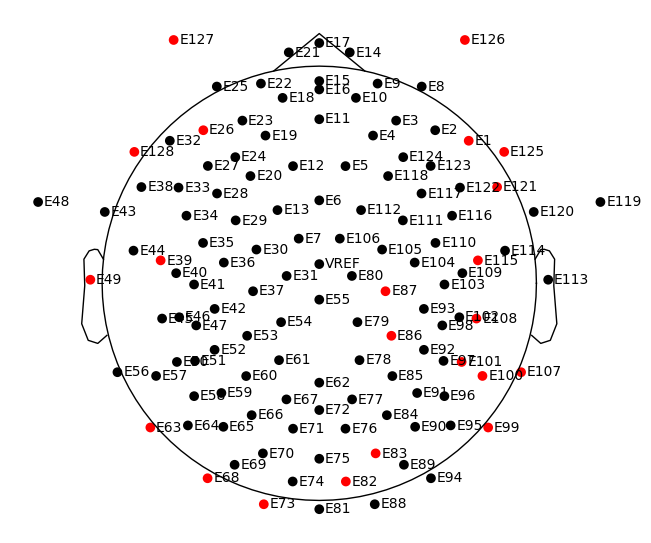

In [7]:
fig = ll_qcr.plot_sensors(show_names=True)

In [8]:
event_id = eeg_event_dict['ae06']
tmin, tmax = -1, 2

epochs_condition_ae06 = mne.Epochs(
    ll_qcr,
    eeg_events,
    event_id,
    tmin,
    tmax,
    baseline=(None, 0),
    preload=True,
)

ch_name = 'E55'
epochs_condition_ae06.pick_channels([ch_name])

Not setting metadata
80 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 80 events and 3001 original time points ...
10 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/IPython/core/formatters.py:347: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  return method()


Number of events,70
Events,3: 70
Time range,-1.000 – 2.000 s
Baseline,-1.000 – 0.000 s


In [9]:
event_id = eeg_event_dict['ae40']
tmin, tmax = -1, 2

epochs_condition_ae40 = mne.Epochs(
    ll_qcr,
    eeg_events,
    event_id,
    tmin,
    tmax,
    baseline=(None, 0),
    preload=True,
)

ch_name = 'E55'
epochs_condition_ae40.pick_channels([ch_name])

Not setting metadata
80 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 80 events and 3001 original time points ...
6 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/IPython/core/formatters.py:347: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  return method()


Number of events,74
Events,5: 74
Time range,-1.000 – 2.000 s
Baseline,-1.000 – 0.000 s


In [10]:
decim = 2
freqs = np.arange(3, 100, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_epochs_1 = tfr_morlet(
    epochs_condition_ae06,
    freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=False,
    average=False,
)

pow_epochs_2 = tfr_morlet(
    epochs_condition_ae40,
    freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=False,
    average=False,
)

#tfr_epochs_1.apply_baseline(mode="ratio", baseline=(None, 0))
#tfr_epochs_2.apply_baseline(mode="ratio", baseline=(None, 0))

epochs_power_1 = pow_epochs_1.data[:, 0, :, :]  # only 1 channel as 3D matrix
epochs_power_2 = pow_epochs_2.data[:, 0, :, :]  # only 1 channel as 3D matrix



/tmp/ipykernel_9743/1936508635.py:5: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  pow_epochs_1 = tfr_morlet(
/tmp/ipykernel_9743/1936508635.py:5: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  pow_epochs_1 = tfr_morlet(


Not setting metadata


/tmp/ipykernel_9743/1936508635.py:14: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  pow_epochs_2 = tfr_morlet(
/tmp/ipykernel_9743/1936508635.py:14: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  pow_epochs_2 = tfr_morlet(


Not setting metadata


In [11]:
threshold = 6.0
F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    [epochs_power_1, epochs_power_2],
    out_type="mask",
    n_permutations=100,
    threshold=threshold,
    tail=0,
)

stat_fun(H1): min=0.000000 max=13.512236
Running initial clustering …
Found 20 clusters


/tmp/ipykernel_9743/1377164585.py:2: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/tmp/ipykernel_9743/1377164585.py:2: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
/tmp/ipykernel_9743/1377164585.py:2: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 99/99 [00:11<00:00,    8.88it/s]


Need more than one channel to make topography for eeg. Disabling interactivity.


/tmp/ipykernel_9743/2129130102.py:27: RuntimeWarning: All-NaN slice encountered
  max_F = np.nanmax(abs(F_obs_plot))


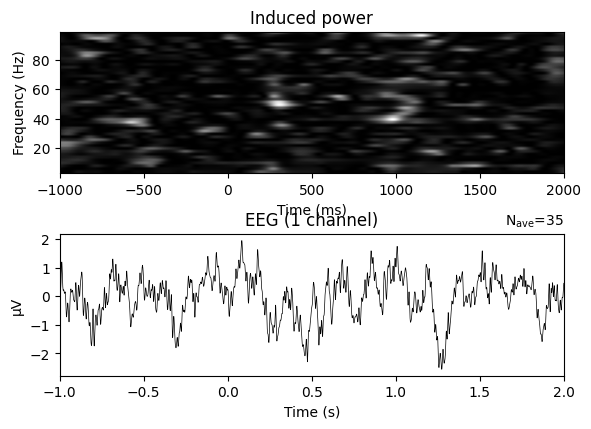

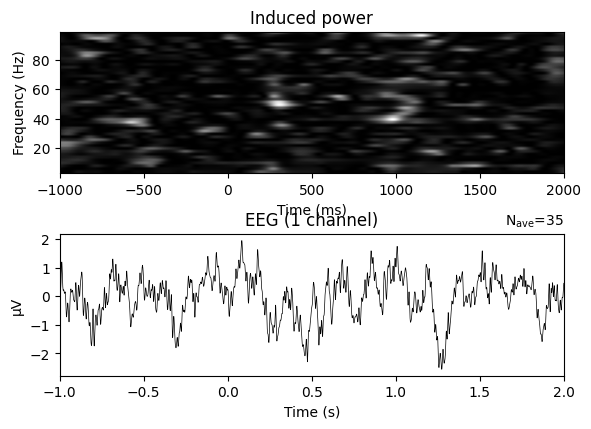

In [12]:
times = 1e3 * epochs_condition_ae06.times  # change unit to ms

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

# Compute the difference in evoked to determine which was greater since
# we used a 1-way ANOVA which tested for a difference in population means
evoked_power_1 = epochs_power_1.mean(axis=0)
evoked_power_2 = epochs_power_2.mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
#signs = np.sign(evoked_power_contrast)
signs = np.sign(evoked_power_contrast)

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        F_obs_plot[c] = F_obs[c] * signs[c]

ax.imshow(
    F_obs,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="gray",
)
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(
    F_obs_plot,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    vmin=-max_F,
    vmax=max_F,
)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Induced power")
#ax.set_title(f"Induced power ({ch_name})")

# plot evoked
evoked_condition_1 = epochs_condition_ae06.average()
evoked_condition_2 = epochs_condition_ae40.average()
evoked_contrast = mne.combine_evoked(
    [evoked_condition_1, evoked_condition_2], weights=[1, -1]
)
evoked_contrast.plot(axes=ax2, time_unit="s")
#evoked_condition_2.plot(axes=ax2, time_unit="s")

In [13]:
decim = 2
freqs = np.arange(2, 100, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_2, itc_2 = tfr_morlet(
    epochs_condition_ae40,
    freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

#pow_2, itc_2 = tfr_morlet(
#    epochs_condition_2,
#    freqs,
#    n_cycles=n_cycles,
#   decim=decim,
#    return_itc=True,
#    average=True,
#)

#tfr_epochs_1.apply_baseline(mode="ratio", baseline=(None, 0))
#tfr_epochs_2.apply_baseline(mode="ratio", baseline=(None, 0))

itc_dat_2 = itc_2.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_2 = pow_2.data[0, :, :]  # only 1 channel as 3D matrix

/tmp/ipykernel_9743/3111410183.py:5: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  pow_2, itc_2 = tfr_morlet(
/tmp/ipykernel_9743/3111410183.py:5: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  pow_2, itc_2 = tfr_morlet(


Text(0.5, 1.0, 'Induced power (E55)')

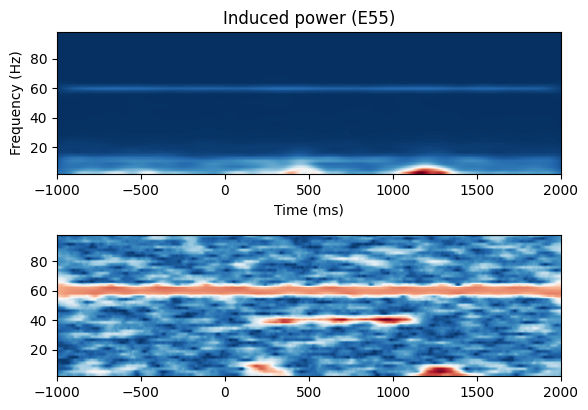

In [14]:
times = 1e3 * epochs_condition_ae40.times  # change unit to ms

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax.imshow(
    pow_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2.imshow(
    itc_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Induced power ({ch_name})")

In [ ]:
# set file variables
#subject_raw_eeg = glob.glob('sourcedata/020_1/020_1_go_*.mff')
subject_raw_eeg = 'sourcedata/024_1/024_1_eeg/024_1_ap_20230710_110505.mff'
subject_raw_et = 'sourcedata/024_1/024_1_eyetracking/024_ap_1.asc'
subject_derivative = 'output_ap/derivatives/pylossless/sub-024/eeg/sub-024_task-ap_eeg.edf'
task_code = 'ap'

In [ ]:
# Load EEG recording
eeg_raw = mne.io.read_raw_egi(subject_raw_eeg)

# Get event info from source recording
eeg_events = mne.find_events(eeg_raw, shortest_event=1)
eeg_event_dict = qst.get_event_dict(eeg_raw, eeg_events)

In [ ]:
eeg_events

In [ ]:
eeg_event_dict

In [ ]:
# Plot channel data only
mne.viz.plot_raw(eeg_raw, events=eeg_events, event_id=eeg_event_dict)

In [ ]:
# Build initial state; nothing applied yet
ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(subject_derivative)

In [ ]:
# Plot channel data only
mne.viz.plot_raw(ll_state.raw, events=eeg_events, event_id=eeg_event_dict)

In [ ]:
# Plot comonents
ll_state.ica2.plot_sources(ll_state.raw)


In [ ]:
# Plot topos
ll_state.ica2.plot_components(inst=ll_state.raw)

In [ ]:
# Merge marks down to bads (aka manual)
ll_qcr = ll_state.raw.copy()
manual = []
for flag_type in ll_state.flags['ch']:
    manual.extend(ll_state.flags['ch'][flag_type])
print(ll_state.flags['ch'])
ll_qcr.info['bads'].extend(manual)
ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))

# Read the ICLabel info from file and add to exclude
df = pd.read_csv(subject_derivative.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)

# Load the data and apply the ICA
ll_qcr.load_data()
ll_state.ica2.apply(ll_qcr)
ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=90.0)
ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
ll_qcr

In [ ]:
# Plot cleaned data
mne.viz.plot_raw(ll_qcr, events=eeg_events, event_id=eeg_event_dict)

In [ ]:
# Take a look at the event dictionairy
eeg_event_dict

In [ ]:
# Relabel condition vars for niceness
#eeg_event_dict['fq06hz/target/disp/ae06'] = eeg_event_dict.pop('ae06')
#eeg_event_dict['fq40hz/target/disp/ae40'] = eeg_event_dict.pop('ae40')

In [ ]:
event_id = 1
tmin, tmax = -1, 2

epochs_condition_40hz = mne.Epochs(
    ll_qcr,
    eeg_events,
    event_id,
    tmin,
    tmax,
    baseline=(None, 0),
    preload=True,
)

ch_name = 'E6'
epochs_condition_40hz.pick_channels([ch_name])

In [ ]:
decim = 2
freqs = np.arange(30, 90, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_1, itc_1 = tfr_morlet(
    epochs_condition_40hz,
    freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

#pow_2, itc_2 = tfr_morlet(
#    epochs_condition_2,
#    freqs,
#    n_cycles=n_cycles,
#   decim=decim,
#    return_itc=True,
#    average=True,
#)

#tfr_epochs_1.apply_baseline(mode="ratio", baseline=(None, 0))
#tfr_epochs_2.apply_baseline(mode="ratio", baseline=(None, 0))

itc_dat_1 = itc_1.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_1 = pow_1.data[0, :, :]  # only 1 channel as 3D matrix

In [ ]:
itc_1.data.shape

In [ ]:
times = 1e3 * epochs_condition_40hz.times  # change unit to ms

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax.imshow(
    pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2.imshow(
    itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Induced power ({ch_name})")

In [ ]:
# Epoch structure is created for ALL events, then you 'segment' by indexing into it
epochs = mne.Epochs(ll_qcr, eeg_events, event_id=eeg_event_dict, tmin=-1, tmax=2.0, on_missing='warn', event_repeated='drop')

In [ ]:
# Check trial counts
epochs[['fq06hz', 'fq15hz']]

In [ ]:
# Plot ERPs
evokeds = {'fq06hz': epochs['fq06hz'].average(), 'fq15hz': epochs['fq15hz'].average()}
mne.viz.plot_compare_evokeds(evokeds, picks=['E72'], combine='mean')

In [ ]:
mne.write_evokeds(f'erp_fif_files/vp/009_1_vp_ave.fif',list(evokeds.values()), overwrite=True)